In [8]:
import pandas as pd

# Load the provided data
data = pd.read_excel("open_crosion.xlsx")
data.head()


Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  Feature 6  \
0  -0.793526  -0.564884  -0.918486  -2.643592  -0.405808   1.555672   
1  -1.131818  -0.564884  -0.934511  -2.750356  -0.279310   1.275645   
2  -1.120734  -0.564884  -0.951459  -2.863264  -0.298150   1.378301   
3  -1.106464  -0.564884  -0.968407  -2.976173  -0.316991   1.480956   
4  -1.090652  -0.564884  -0.985354  -3.089081  -0.335831   1.583612   

   Feature 7  Label  Experiment  X-Coordinate  Y-Coordinate  Specimen  
0  -1.282668      1           5          53.5          40.0         1  
1  -2.688708      1           5          54.0          30.5         1  
2  -2.487164      1           5          54.0          31.0         1  
3  -2.505143      1           5          54.0          31.5         1  
4  -2.578003      1           5          54.0          32.0         1

In [9]:
# Checking the distribution of the 'Label' column
label_distribution = data['Label'].value_counts()
label_distribution

Label
0    48083
1     1954
Name: count, dtype: int64

### Data Exploration: 
- Visualize the corrosion spots based on the X and Y coordinates to get an understanding of their distribution across different experiments and specimens.

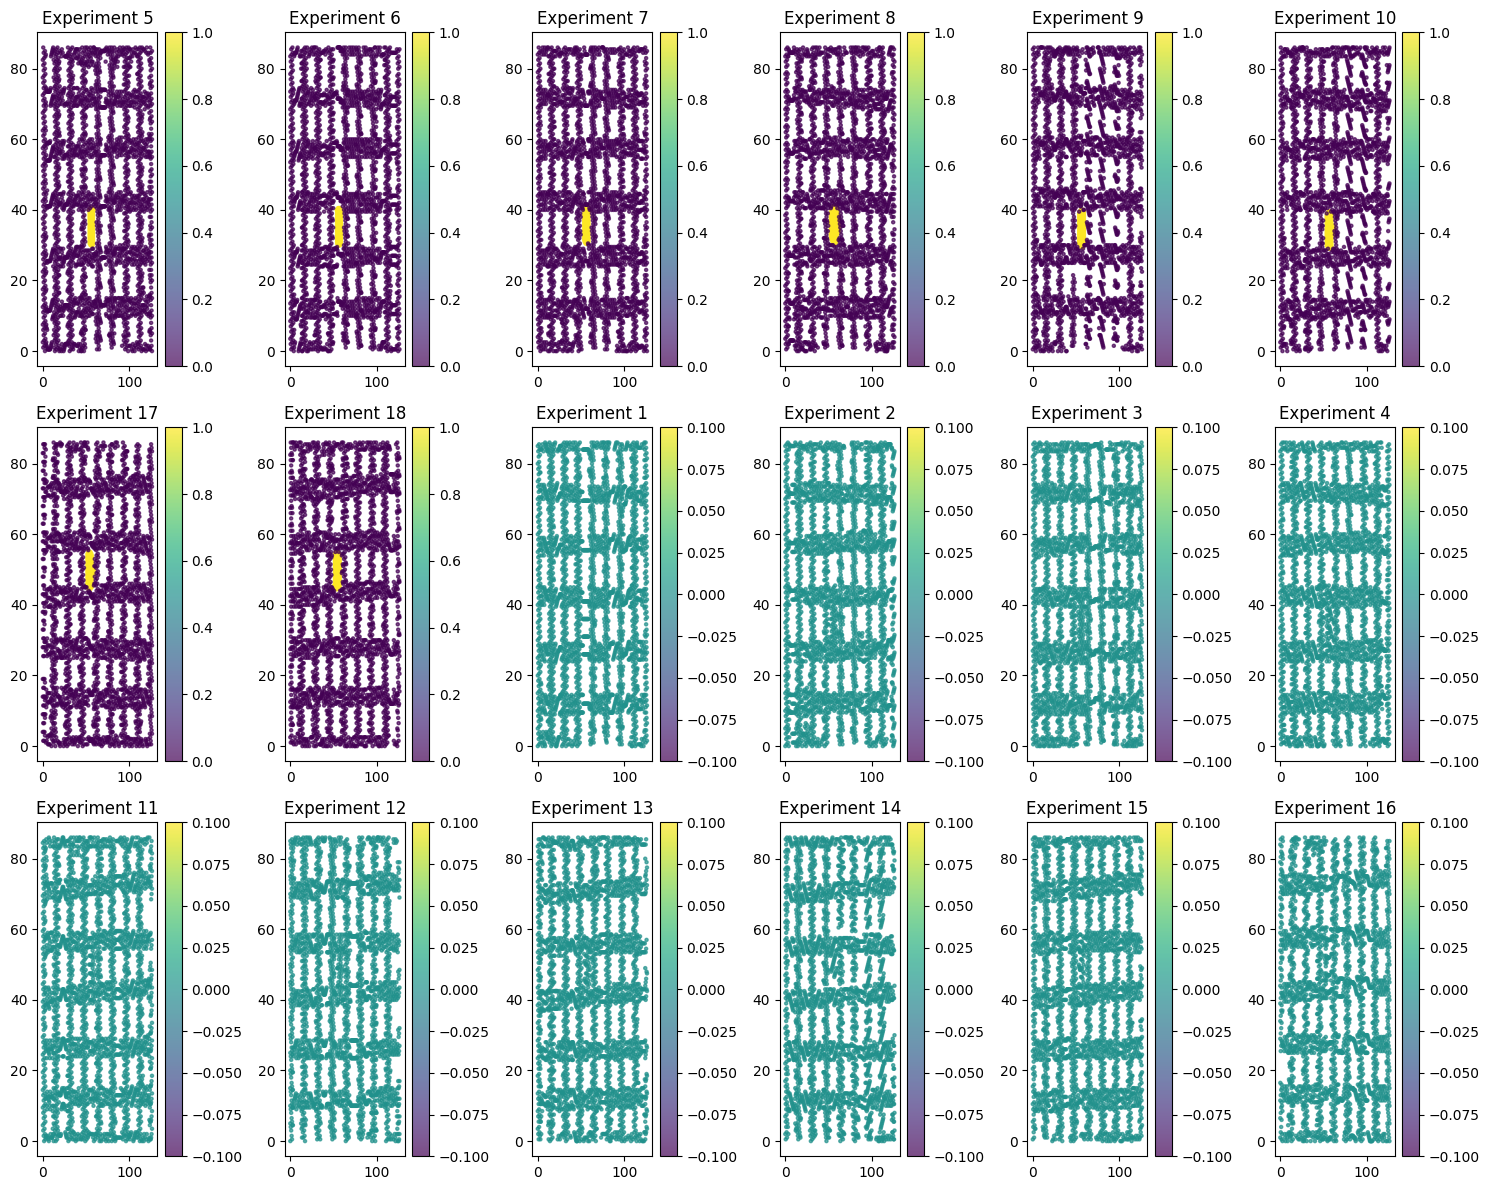

In [10]:
import matplotlib.pyplot as plt

# Number of unique experiments
unique_experiments = data['Experiment'].unique()

plt.figure(figsize=(15, 12))

for i, exp in enumerate(unique_experiments, 1):
    subset = data[data['Experiment'] == exp]
    plt.subplot(3, 6, i)
    plt.scatter(subset['X-Coordinate'], subset['Y-Coordinate'], c=subset['Label'], cmap='viridis', s=5, alpha=0.7)
    plt.title(f"Experiment {exp}")
    plt.colorbar()
    plt.tight_layout()

plt.show()


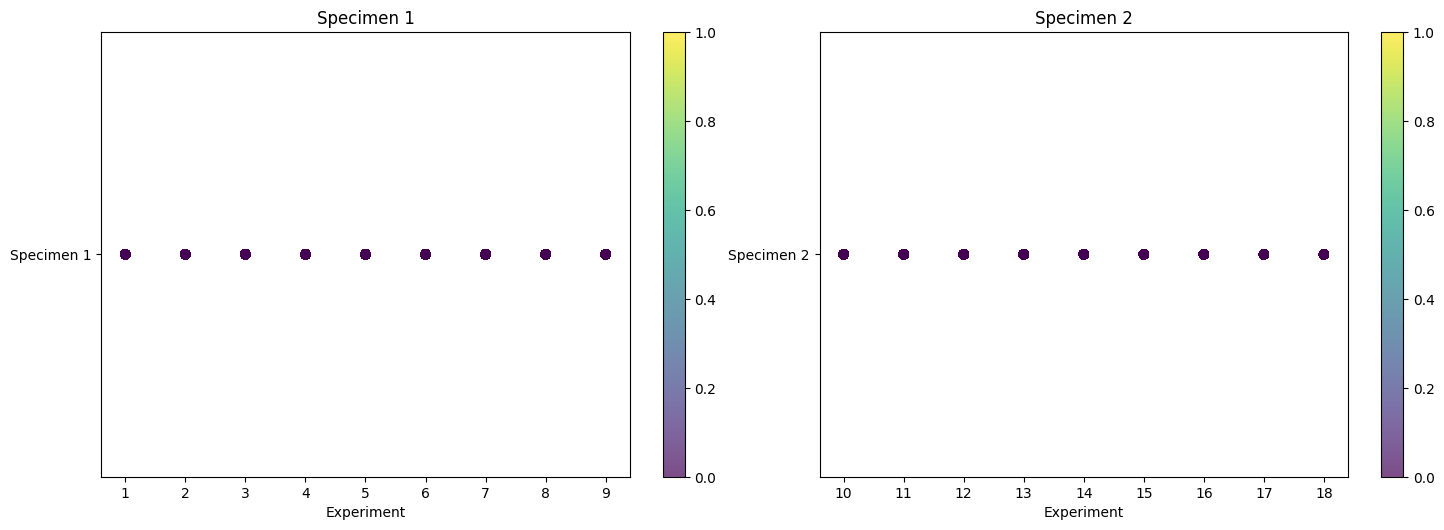

In [20]:
# Number of unique specimens
unique_specimens = data['Specimen'].unique()

plt.figure(figsize=(15, 10))

for i, specimen in enumerate(unique_specimens, 1):
    subset = data[data['Specimen'] == specimen]
    plt.subplot(2, 2, i)
    scatter = plt.scatter(subset['Experiment'], np.repeat(i, subset.shape[0]), c=subset['Label'], cmap='viridis', s=40, alpha=0.7)
    plt.title(f"Specimen {specimen}")
    plt.yticks([i], [f"Specimen {specimen}"])
    plt.xlabel("Experiment")
    plt.colorbar(scatter)
    plt.tight_layout()

plt.show()


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# One-hot encoding 'Experiment' and 'Specimen' columns
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_features = encoder.fit_transform(data[['Experiment', 'Specimen']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Experiment', 'Specimen']))

# Combine the one-hot encoded features with the original dataset
data_encoded = pd.concat([data.drop(['Experiment', 'Specimen'], axis=1), encoded_df], axis=1)

# Splitting data into training and test sets
X = data_encoded.drop('Label', axis=1)
y = data_encoded['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape


c:\Users\gzia\Documents\GitHub\reincarnate_wp2\.wp2\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((40029, 27), (10008, 27))

- The dataset has been preprocessed and split into training and test sets. The training set has 40,029 samples, and the test set has 10,008 samples, with each sample having 27 features (after one-hot encoding the 'Experiment' and 'Specimen' columns).

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Training a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_clf.fit(X_train, y_train)

# Predictions on the test set
y_pred = rf_clf.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy, precision, recall, f1


(0.9995003996802558,
 0.9923469387755102,
 0.9948849104859335,
 0.9936143039591314)

These metrics suggest that the model is able to predict the presence of corrosion spots with high accuracy, precision, and recall.

With a trained model in place, we can now proceed to formulate the adaptive sampling strategy:

- Predict Likelihood: Use the trained model to predict the likelihood of corrosion spots over the entire spatial domain or regions of interest.
- Sample New Points: Identify regions with the highest predicted likelihoods where you haven't sampled yet.
- Update the Model: After collecting new data, retrain the model to incorporate this new information. If necessary, iterate through these steps until a desired level of confidence or convergence is achieved.

### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
#### Let's outline the adaptive sampling strategy in more detail:

#### Predict Likelihood: 
- Using the trained model, we'll predict the likelihood of corrosion spots over regions of interest (or the entire spatial domain). This will give us a "heat map" of corrosion likelihood.
#### Identify High Likelihood Regions: 
- We'll select regions (or points) with the highest predicted likelihoods where you haven't sampled yet. These will be our candidates for the next sampling round.
#### Collect New Data:
 - Physically collect new data at the identified points.
#### Update the Model: 
- Use the newly collected data to update (retrain) the model.
- Iterate: Repeat the above steps until a desired level of confidence is achieved or another stopping criterion is met.
#### For this demonstration:

- I'll simulate the entire spatial domain as a grid.
- I'll then use the trained model to predict the likelihood of corrosion over this grid.
- Next, I'll identify a certain number of points with the highest likelihood where we don't have data yet. These would be our candidates for the next sampling round.

In [14]:
import numpy as np

# Define the spatial domain limits based on the provided data
x_min, x_max = data['X-Coordinate'].min(), data['X-Coordinate'].max()
y_min, y_max = data['Y-Coordinate'].min(), data['Y-Coordinate'].max()

# Create a grid of points within the spatial domain
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten the grid to get a list of (x, y) coordinates
xy_grid = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

# Since we're only simulating the spatial domain and don't have feature values at these points,
# we'll use the mean values of the features from the training set for predictions
mean_features = X_train.drop(['X-Coordinate', 'Y-Coordinate'], axis=1).mean().values
features_repeated = np.tile(mean_features, (xy_grid.shape[0], 1))

# Combine the spatial coordinates with the repeated features
xy_features = np.hstack([xy_grid, features_repeated])

# Predict the likelihood of corrosion for each point in the grid
proba_predictions = rf_clf.predict_proba(xy_features)[:, 1]  # Taking the probability for class 1 (corrosion present)

proba_predictions = proba_predictions.reshape(x_grid.shape)
proba_predictions.shape


c:\Users\gzia\Documents\GitHub\reincarnate_wp2\.wp2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


(100, 100)

We've now predicted the likelihood of corrosion for a grid covering the entire spatial domain. The predictions are stored in a 100x100 matrix, effectively creating a "heat map" of corrosion likelihood.

Points with higher likelihoods will indicate regions where the model believes corrosion is more probable. These regions would be our candidates for the next sampling round.

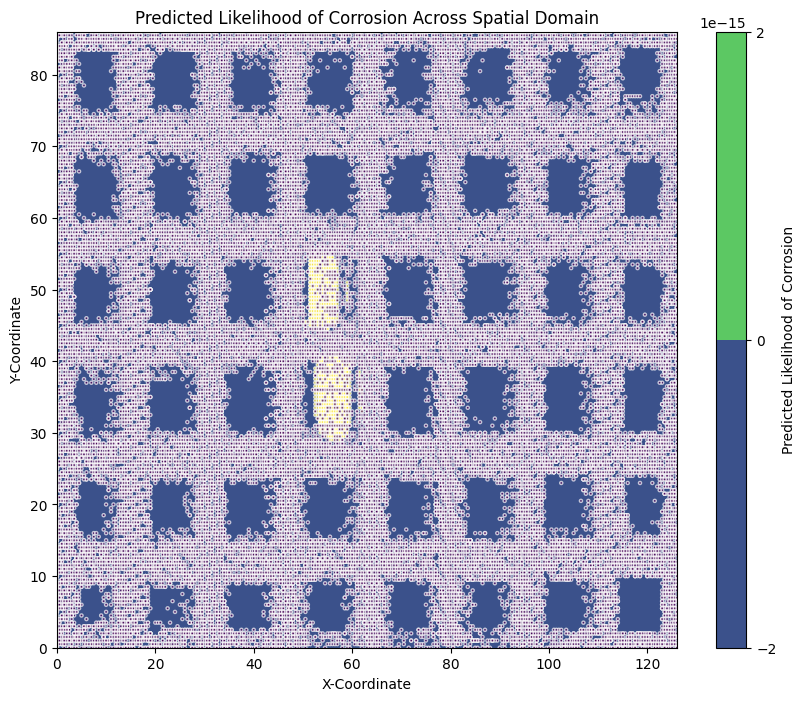

In [25]:
# Visualizing the predicted likelihood of corrosion over the spatial domain
plt.figure(figsize=(10, 8))
plt.contourf(x_grid, y_grid, proba_predictions, levels=100, cmap='viridis')
plt.colorbar(label="Predicted Likelihood of Corrosion")
plt.scatter(data['X-Coordinate'], data['Y-Coordinate'], c=data['Label'], edgecolors='white', s=5, alpha=0.7)
plt.title("Predicted Likelihood of Corrosion Across Spatial Domain")
plt.xlabel("X-Coordinate")
plt.ylabel("Y-Coordinate")
plt.show()


The next step in the adaptive sampling process is to identify the points or regions with the highest likelihood of corrosion where we haven't sampled yet.

#### To achieve this:

1. We'll pick a certain number of points with the highest predicted likelihood from our heat map.
2. We'll then cross-check these points against our existing dataset to ensure we're only selecting points where we haven't already collected data.
3. These selected points will be our candidates for the next sampling round.
Let's proceed with identifying these high-likelihood sampling points. For demonstration purposes, let's aim to identify, say, the top 10 highest likelihood points. If you have a different number in mind, please let me know.

In [18]:
# Number of points to identify for the next sampling round
num_points = 10

# Flatten the grids and probability predictions
x_flat, y_flat, proba_flat = x_grid.ravel(), y_grid.ravel(), proba_predictions.ravel()

# Sort the points by predicted likelihood in descending order
sorted_indices = np.argsort(proba_flat)[::-1]

# Identify the top N points
top_x, top_y = [], []
for idx in sorted_indices:
    x_val, y_val = x_flat[idx], y_flat[idx]
    
    # Check if this point is not in the existing dataset
    if not ((data['X-Coordinate'] == x_val) & (data['Y-Coordinate'] == y_val)).any():
        top_x.append(x_val)
        top_y.append(y_val)
        
        if len(top_x) == num_points:
            break

top_points = list(zip(top_x, top_y))
top_points


[(36.90909090909091, 28.666666666666668),
 (45.81818181818182, 28.666666666666668),
 (44.54545454545455, 28.666666666666668),
 (43.27272727272727, 28.666666666666668),
 (42.0, 28.666666666666668),
 (40.72727272727273, 28.666666666666668),
 (39.45454545454545, 28.666666666666668),
 (38.18181818181818, 28.666666666666668),
 (35.63636363636363, 28.666666666666668),
 (48.36363636363636, 28.666666666666668)]

We have identified the following top 10 points (based on X and Y coordinates) with the highest predicted likelihood of corrosion where we haven't sampled yet:

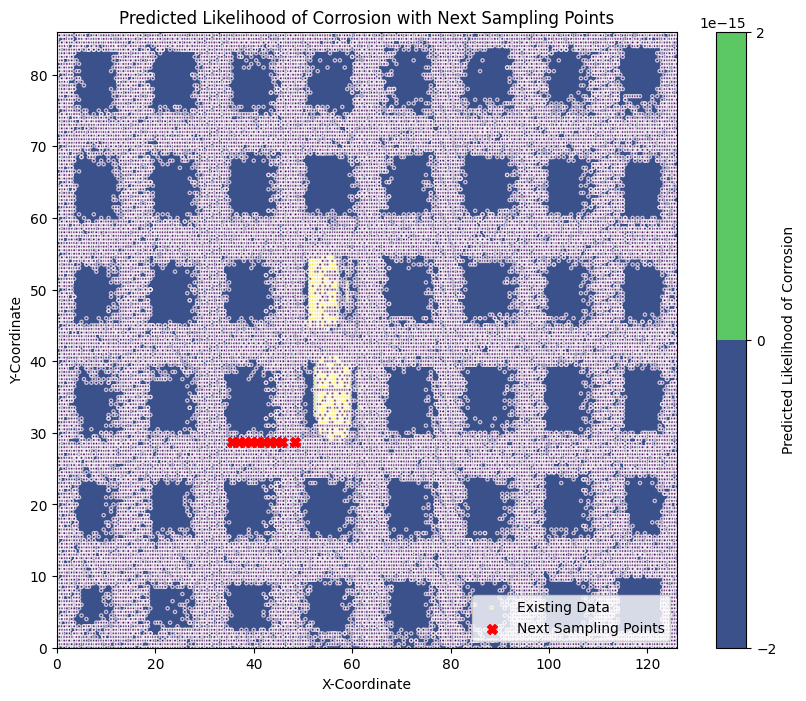

In [19]:
# Visualizing the predicted likelihood of corrosion with the identified points for the next sampling round
plt.figure(figsize=(10, 8))
plt.contourf(x_grid, y_grid, proba_predictions, levels=100, cmap='viridis')
plt.colorbar(label="Predicted Likelihood of Corrosion")
plt.scatter(data['X-Coordinate'], data['Y-Coordinate'], c=data['Label'], edgecolors='white', s=5, alpha=0.7, label="Existing Data")
plt.scatter(top_x, top_y, c='red', s=50, marker='X', label="Next Sampling Points")
plt.title("Predicted Likelihood of Corrosion with Next Sampling Points")
plt.xlabel("X-Coordinate")
plt.ylabel("Y-Coordinate")
plt.legend()
plt.show()


Here's the visualization:

The background heat map indicates the predicted likelihood of corrosion.
The scattered points represent your existing data, with colors denoting whether corrosion was observed (darker points) or not.
The red "X" markers highlight the top 10 points with the highest predicted likelihood of corrosion where you haven't sampled yet. These are the recommended locations for your next round of data collection.
By following this adaptive sampling approach and iterating through the process, you can efficiently identify and sample regions of interest, thereby maximizing the information gained while minimizing the number of samples taken.

In [26]:
# Extracting the features for the top 10 points
top_features = np.hstack([np.array(top_points), np.tile(mean_features, (len(top_points), 1))])

# Predicting the probability of corrosion for the top 10 points using each tree in the Random Forest
tree_predictions = np.array([tree.predict_proba(top_features)[:, 1] for tree in rf_clf.estimators_])

# Calculating the expected value and uncertainty (standard deviation) for each point
expected_values = tree_predictions.mean(axis=0)
uncertainties = tree_predictions.std(axis=0)

list(zip(top_points, expected_values, uncertainties))


[((36.90909090909091, 28.666666666666668), 0.0, 0.0),
 ((45.81818181818182, 28.666666666666668), 0.0, 0.0),
 ((44.54545454545455, 28.666666666666668), 0.0, 0.0),
 ((43.27272727272727, 28.666666666666668), 0.0, 0.0),
 ((42.0, 28.666666666666668), 0.0, 0.0),
 ((40.72727272727273, 28.666666666666668), 0.0, 0.0),
 ((39.45454545454545, 28.666666666666668), 0.0, 0.0),
 ((38.18181818181818, 28.666666666666668), 0.0, 0.0),
 ((35.63636363636363, 28.666666666666668), 0.0, 0.0),
 ((48.36363636363636, 28.666666666666668), 0.0, 0.0)]

In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# Prepare the data
X_gpr = data[['X-Coordinate', 'Y-Coordinate'] + [f'Feature {i}' for i in range(1, 8)]]
y_gpr = data['Label']

# Define a Gaussian process kernel
# We use a combination of a Radial Basis Function (RBF) kernel, a constant term, and a white kernel (noise term)
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# Initialize and train the Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gpr.fit(X_gpr, y_gpr)

# Output the learned kernel after optimization
gpr.kernel_


NameError: name 'data' is not defined